In [1]:
from pathlib import Path
import shutil

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Helper functions for plotting the confusion matrix and annotating it
from plots import heatmap, annotate_heatmap

In [2]:
def import_data(fn):
    
    '''
    Read the data file with rows formatted as {label, features},
    each corresponding to a data point.
    
    Parameters
    ----------
    fn: string
        name of the file to read
    
    Returns
    -------
    inputs: np.ndarray
        array of shape (N, D) with pixel values laid out in rows
    labels: np.ndarray
        array of shape (N,) with labels of the data points
    '''

    data = np.loadtxt(fn)
    inputs, labels = data[:, 1:], data[:, 0]

    return inputs, labels

X, Y = import_data('zipcombo.dat')
N_CLASSES = 10

In [3]:
class BaseKernel:

    '''
    Define basic operations used by implementations of the polynomial 
    and the Gaussian kernels.

    Attributes
    ----------
    base_kernel_matrix: np.ndarray
        array of shape (N, M) where N is the number of samples in the 
        first dataset (eg. test) and M is for the second (eg. train)
    
    Methods
    -------
    base_kernel(X1, X2):
        evaluate the Gram matrix between X1 and X2 using the base kernel
    indices(row_indices, col_indices):
        process the requested indices for calculating the Gram matrix to
        avoid runtime errors
    kernel(hparam, row_indices, col_indices):
        calculate the Gram matrix for the requested pairs of data points
        using the specified hyper-parameter
    '''

    def __init__(self, X1, X2=None):
        self.base_kernel_matrix = self.base_kernel(X1, X2 if X2 is not None else X1)

    def base_kernel(self, X1, X2):
        raise NotImplementedError
    
    def indices(self, row_indices, col_indices):

        '''
        Check the indices requested from {X1} and {X2} respectively, and
        format them to be a valid index for the {base_kernel_matrix}
        
        Parameters
        ----------
        row_indices: np.ndarray
            sequence of N indices requested from {X1}
        col_indices: np.ndarray
            sequence of M indices requested from {X2}
        
        Returns
        -------
        indices: np.ndarray
            2 arrays with 2 dimensions each, which together form an open mesh
        '''
        
        # if row_indices is None, return all rows
        if row_indices is None:
            row_indices = np.arange(self.base_kernel_matrix.shape[0])
        # if col_indices is None, return all columns
        if col_indices is None:
            col_indices = np.arange(self.base_kernel_matrix.shape[1])
            
        return np.ix_(row_indices, col_indices)
    
    def kernel(self, hparam, row_indices=None, col_indices=None):
        raise NotImplementedError

In [4]:
class PolynomialKernel(BaseKernel):

    '''
    Compute the polynomial kernel by first precomputing the pairwise 
    inner products, and then raising them to the degree, {d}.

    Attributes
    ----------
    base_kernel_matrix: np.ndarray
        matrix containing pairwise inner products (d=1)
    
    Methods
    -------
    base_kernel(X1, X2):
        evaluate the pairwise inner products (d=1) between {X1} and {X2}
    kernel(hparam, row_indices, col_indices):
        evaluate the polynomial kernel of degree {d} by raising the
        {base_kernel_matrix} to power {d}
    '''

    def __init__(self, X1, X2=None):
        super().__init__(X1, X2)

    def base_kernel(self, X1, X2):

        '''
        Evaluate the pairwise inner products (d=1) between {X1} and {X2}
        
        Parameters
        ----------
        X1: np.ndarray
            first data matrix of shape (N, D)
        X2: np.ndarray
            second data matrix of shape (M, D)
        
        Returns
        -------
        dot_products: np.ndarray
            kernel matrix of shape (N, M) containing pariwise inner products
        '''
        
        # evaluate the {base_kernel_matrix} as pairwise inner products
        dot_products = X1 @ X2.T

        return dot_products
    
    def kernel(self, hparam, row_indices=None, col_indices=None):

        '''
        Check the indices requested from {X1} and {X2} respectively, and
        format them to be a valid index for the {base_kernel_matrix}
        
        Parameters
        ----------
        hparam: int
            degree of the polynomial kernel
        row_indices: np.ndarray
            sequence of N indices requested from {X1}
        col_indices: np.ndarray
            sequence of M indices requested from {X2}
        
        Returns
        -------
        kernel_matrix: np.ndarray
            kernel matrix of shape ({len(row_indices)}, {len(col_indices)})
            evaluated using the polynomial kernel of degree {hparam}
        '''

        # get a valid index for the {base_kernel_matrix}
        indices = self.indices(row_indices, col_indices)
        # evaluate the kernel matrix as the d-th power of the inner products
        kernel_matrix = np.power(self.base_kernel_matrix[indices], hparam)

        return kernel_matrix
    
full_kernel = PolynomialKernel(X)
D = range(1, 8)

In [5]:
def init_coefs(n_classifiers, train_size):

    '''
    Initialize the multi-class perceptron coefficients as 0s. 
    
    Parameters
    ----------
    n_classifiers: int
        number of classifiers -- 10 for OvA and 45 for OvO
    train_size: int
        number of training points
    
    Returns
    -------
    coefs: np.ndarray
        0 initialized array of shape ({n_classifiers}, {train_size})
        containing the coefficients of the kernel perceptrons
    '''
    
    coefs = np.zeros((n_classifiers, train_size))
    return coefs
    
def predict(coefs, kernel_values):

    '''
    Predict the pre-activation output for given classifiers at given 
    test points. 
    
    Parameters
    ----------
    coefs: np.ndarray
        2-D array containing the coefficients of the classifiers
        we want predictions for
    kernel_values: np.ndarray
        2-D array containing the kernel evaluations between the test
        points and the training points
    
    Returns
    -------
    predictions: np.ndarray
        output of the affine map, computed before applying the 
        Heaviside non-linearity
    '''

    predictions = coefs @ kernel_values.T
    return predictions

def sign(x):

    '''
    Compute the sign function evaluation for the entries in the input.
    
    Parameters
    ----------
    x: np.ndarray
        n-D input array 
    
    Returns
    -------
    signs: np.ndarray
        sign function output for the array entries
    '''

    return np.where(x <= 0., -1., 1.)

In [6]:
def train(train_kernel, train_y, coefs, n_epochs=1):

    '''
    Train the k-class kernel perceptron using One-vs-All generalization.
    
    Parameters
    ----------
    train_kernel: np.ndarray
        pairwise kernel evaluations for the training points
    train_y: np.ndarray
        labels for the training set
    coefs: np.ndarray
        k-class kernel perceptron coefficients
    n_epochs: int
        number of epochs to train the classifier for

    Returns
    -------
    coefs: np.ndarray
        updated coefficients of the k-class kernel perceptron
    mistakes: List[int]
        mistakes made on the training set in each epoch
    '''
    
    # keep track of the mistakes made on the training set in each epoch
    mistakes = [0 for _ in range(n_epochs)]
    for epoch in range(n_epochs):
        for i in range(train_y.size):
            # retrieve the kernel evaluations between the new training point and the old ones
            features, y = train_kernel[i], train_y[i]
            # predict the pre-activation outputs and the class prediction
            predictions = predict(coefs, features); argmax = np.argmax(predictions)
            # if the prediction doesn't match the label, increment the number of mistakes
            if argmax != y:
                mistakes[epoch] += 1
            # set the label for the classifier corresponding to the class {y} as 1 and -1 for the rest 
            labels = np.full(coefs.shape[0], -1.); labels[int(y)] = 1.
            # update the coefficients for the classifiers which made a mistake
            updates = np.where(labels*predictions <= 0., sign(predictions), 0.)
            coefs[:, i] -= updates

    return coefs, mistakes

def test(test_kernel, test_y, coefs, return_cm=False):

    '''
    Test the k-class perceptron using One-vs-All generalization.
    
    Parameters
    ----------
    test_kernel: np.ndarray
        pairwise kernel evaluations for the test points with training points
    train_y: np.ndarray
        labels for the testing set
    coefs: np.ndarray
        k-class kernel perceptron coefficients
    return_cm: bool
        Boolean value indicating whether to return the confusion matrix

    Returns
    -------
    mistakes: int
        mistakes made on the testing set
    confusion_matrix: np.ndarray (returned only if {return_cm} is True)
        confusion matrix with labels indexed as rows and predictions as columns
    '''

    # make the pre-activation predictions on the test set
    predictions = predict(coefs, test_kernel)
    # compute the class prediction as the argmax of outputs of the classifiers 
    argmax = np.argmax(predictions, axis=0)
    # compute mistakes as the number of incorrectly predicted labels
    mistakes = np.sum(argmax != test_y)
    yield mistakes

    # compute and yield the confusion matrix if {return_cm} is True
    if return_cm:
        confusion_matrix = np.zeros((N_CLASSES, N_CLASSES))
        np.add.at(confusion_matrix, (test_y.astype(int), argmax), 1.)
        yield confusion_matrix
    else:
        yield None

### Demo

In [7]:
def execute_run(train_x, train_y, test_x, test_y, d, n_classes, n_epochs):

    '''
    Demo run with a subset of data corresponding to the classes 1-3.

    Parameters
    ----------
    train_x: np.ndarray
        training data inputs with features along the rows
    train_y: np.ndarray
        training data labels
    test_x: np.ndarray
        testing data inputs with features along the rows
    test_y: np.ndarray
        testing data labels
    d: int
        polynomial kernel dimension
    n_classes: int
        number of classes in the demo dataset
    n_epochs: int
        number of epochs to train the classifier for

    Returns
    -------
    coefs: np.ndarray
        {n_classes}-class kernel perceptron coefficients
    '''

    # compute kernel matrix for the training set using a polynomial kernel of degree d
    train_kernel = PolynomialKernel(train_x).kernel(d)
    # compute kernel matrix for the testing set using a polynomial kernel of degree d
    test_kernel = PolynomialKernel(test_x, train_x).kernel(d)
    # initialize the coefficients for the {n_classes}-class kernel perceptron
    coefs = init_coefs(n_classes, train_x.shape[0])
    
    for i in range(1, n_epochs+1):
        # train the perceptron for one epoch
        coefs, train_mistakes = train(train_kernel, train_y, coefs, n_epochs=1)
        # test it using the updated coefficients after {i} epochs
        test_mistakes, _ = test(test_kernel, test_y, coefs, return_cm=False)
        # log the results on the training and the testing sets
        print(f'Epoch {i} - {train_mistakes[-1]} mistakes out of {train_x.shape[0]} items on training set, test error is {test_mistakes/test_x.shape[0]*100:.3f}%.')

In [8]:
train_x, train_y = import_data('dtrain123.dat')
test_x, test_y = import_data('dtest123.dat')

execute_run(train_x, train_y-1, test_x, test_y-1, d=3, n_classes=3, n_epochs=3)

Epoch 1 - 15 mistakes out of 329 items on training set, test error is 3.509%.
Epoch 2 - 3 mistakes out of 329 items on training set, test error is 2.851%.
Epoch 3 - 0 mistakes out of 329 items on training set, test error is 2.632%.


### Choice of Number of Epochs

In [9]:
n_runs, n_epochs = 100, 10

train_error_rates = np.zeros((n_runs, n_epochs))
test_error_rates = np.zeros((n_runs, n_epochs))

for run in range(n_runs):
    
    # use a random polynomial kernel of degree between 1 and 7
    hparam = np.random.choice(D)
    full_kernel_h = full_kernel.kernel(hparam)    
    # make a 80-20 train-test split
    train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
    # extract the features for the training and the testing sets
    train_kernel, test_kernel = full_kernel_h[np.ix_(train_indices, train_indices)], full_kernel_h[np.ix_(test_indices, train_indices)]
    # extract the labels for the training and the testing sets
    train_y, test_y = Y[train_indices], Y[test_indices]
    # initialize the coefficients
    coefs = init_coefs(N_CLASSES, train_indices.size)

    for epoch in range(n_epochs):
        # train the generalized kernel perceptron for {n_epochs}
        coefs, (train_mistakes,) = train(train_kernel, train_y, coefs, n_epochs=1)
        train_error_rates[run, epoch] = train_mistakes/train_y.size
        # test the learnt generalized kernel perceptron
        test_mistakes, _ = test(test_kernel, test_y, coefs, return_cm=False)
        test_error_rates[run, epoch] = test_mistakes/test_y.size

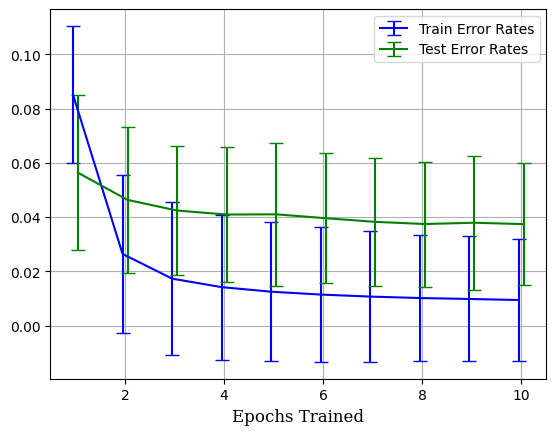

In [10]:
plt.errorbar(np.arange(n_epochs)+0.95, np.mean(train_error_rates, axis=0), yerr=np.std(train_error_rates, axis=0), capsize=5, color='blue', label='Train Error Rates')
plt.errorbar(np.arange(n_epochs)+1.05, np.mean(test_error_rates, axis=0), yerr=np.std(test_error_rates, axis=0), capsize=5, color='green', label='Test Error Rates')
plt.xlabel('Epochs Trained', font='serif', size=12)
plt.legend()
plt.grid()
plt.show()

In [11]:
# We see marginal improvement in test performance beyond epoch 5, so we execute 
N_EPOCHS = 4

### Question 1

In [12]:
# One-vs-All generalization of a perceptron to k-classes
n_classifiers = N_CLASSES

In [13]:
def question_1(n_runs, hparams, n_epochs):

    '''
    Perform k-class kernel perceptron training for different values of hyper-parameter choice.

    Parameters
    ----------
    n_runs: int
        number of runs to perform with each hyper-parameter choice
    hparams: Iterable
        a sequence of hyper-parameter choices
    n_epochs: int
        number of epochs to train the perceptron for in each run

    Returns
    -------
    error_rates: Dict
        dictionary pointing to mean and standard deviation of error rates over {n_runs} runs
        computed for each choice of the hyper-parameter
    '''

    # store results on the training and the test sets
    # {value[run, i]} records the number of mistakes in {run}-th run using hyper-parameter {hparams[i]} 
    error_rates = {'train': np.zeros((n_runs, len(hparams))), 'test': np.zeros((n_runs, len(hparams)))}

    for i in range(len(hparams)):

        # extract the hyper-parameter value
        hparam = hparams[i]
        # compute the kernel matrix from the {base_kernel_matrix} using the hyper-parameter value
        full_kernel_h = full_kernel.kernel(hparam)

        for run in range(n_runs):

            # make a 80-20 train-test split
            train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
            # extract the features for the training and the testing sets
            train_kernel, test_kernel = full_kernel_h[np.ix_(train_indices, train_indices)], full_kernel_h[np.ix_(test_indices, train_indices)]
            # extract the labels for the training and the testing sets
            train_y, test_y = Y[train_indices], Y[test_indices]

            # initialize the coefficients
            coefs = init_coefs(n_classifiers, train_indices.size)
            # train the generalized kernel perceptron for {n_epochs}
            coefs, train_mistakes = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
            # test the learnt generalized kernel perceptron
            test_mistakes, _ = test(test_kernel, test_y, coefs, return_cm=False)
            
            # update logs
            error_rates['train'][run, i] = train_mistakes[-1]/train_y.size
            error_rates['test'][run, i] = test_mistakes/test_y.size

    # calculate the mean and standard deviation of the error rates on training and testing sets
    error_rates['train'] = [f'{100*m:.3f} ± {100*s:.3f}' for m, s in zip(np.mean(error_rates['train'], axis=0), np.std(error_rates['train'], axis=0))]
    error_rates['test']  = [f'{100*m:.3f} ± {100*s:.3f}' for m, s in zip(np.mean(error_rates['test'], axis=0),  np.std(error_rates['test'], axis=0))]

    return error_rates

In [14]:
N_RUNS = 20
error_rates = question_1(n_runs=N_RUNS, hparams=D, n_epochs=N_EPOCHS)

df = pd.DataFrame(data=zip(*error_rates.values()), index=D, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Degree')
df

,Train error (%),Test error (%)
Degree,,
1,8.161 ± 0.188,9.683 ± 1.200
2,1.271 ± 0.115,3.852 ± 0.760
3,0.405 ± 0.069,3.535 ± 1.204
4,0.225 ± 0.057,2.938 ± 0.406
5,0.135 ± 0.046,2.930 ± 0.312
6,0.102 ± 0.033,2.906 ± 0.356
7,0.080 ± 0.026,2.938 ± 0.426


### Questions 2 and 3

In [15]:
def question_2(n_runs, n_splits, hparams, n_epochs, return_cm=True):

    '''
    Find the sample statistics of the estimate for best hyper-parameter choice by performing 
    k-class kernel perceptron training with different values of hyper-parameter choice.

    Parameters
    ----------
    n_runs: int
        number of runs to perform with each hyper-parameter choice
    n_splits: int
        number of splits used for cross-validation
    hparams: Iterable
        a sequence of hyper-parameter choices
    n_epochs: int
        number of epochs to train the perceptron for in each run
    return_cm: bool
        Boolean value indicating whether to return the confusion matrix

    Returns
    -------
    results: Dict
        - results['hparam_star'] is an array storing the best hyper-parameter from each run 
        found using cross-validation
        - results['test_error'] is an array storing the test error for the classifier trained
        with the best hyper-parameter from each run
    confusion_matrix: np.ndarray (returned only if {return_cm} is True)
        confusion matrix with labels indexed as rows and predictions as columns
    '''

    # 5-fold splitter for cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # confusion matrix for each run
    confusion_matrix = [None for _ in range(n_runs)]
    # best hyper-parameter found in each run using cross-validation and the corresponding test error 
    results = {'hparam_star': np.zeros((n_runs,)), 'test_error': np.zeros((n_runs,))}

    for run in range(n_runs):
        
        # split the data indices into train and test sets
        train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
        
        # initialize an array for storing the validation errors corresponding to each hyper-parameter choice
        val_errors = np.zeros((len(hparams), n_splits))
        for i, hparam in enumerate(hparams):
            # compute the full kernel matrix corresponding to the hyper-parameter choice
            full_kernel_h = full_kernel.kernel(hparam)
            for fold, (train_fold, val_fold) in enumerate(kfold.split(train_indices)):
                # extract the features for the training and the validation sets
                train_kernel, val_kernel = full_kernel_h[np.ix_(train_fold, train_fold)], full_kernel_h[np.ix_(val_fold, train_fold)]
                # extract the labels for the training and the validation sets
                train_y, val_y = Y[train_fold], Y[val_fold]
                # initialize the coefficients
                coefs = init_coefs(n_classifiers, train_fold.size)
                # train the generalized kernel perceptron for {n_epochs}
                coefs, _ = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
                # validate the learnt generalized kernel perceptron
                val_mistakes, _ = test(val_kernel, val_y, coefs, return_cm=False)
                val_errors[i, fold] = val_mistakes/val_y.size
        
        # take the mean of the validation errors on the {n_splits} folds
        val_errors = val_errors.mean(axis=1)
        # compute the best hyper-parameter as the one with the minimum mean validation error
        hparam_star = hparams[np.argmin(val_errors)]; results['hparam_star'][run] = hparam_star

        # recompute the kernel matrix using the best hyper-parameter 
        full_kernel_h = full_kernel.kernel(hparam_star)
        # extract the features for the training and the testing sets
        train_kernel, test_kernel = full_kernel_h[np.ix_(train_indices, train_indices)], full_kernel_h[np.ix_(test_indices, train_indices)]
        # extract the labels for the training and the testing sets
        train_y, test_y = Y[train_indices], Y[test_indices]
        # initialize the coefficients
        coefs = init_coefs(n_classifiers, train_indices.size)
        # train the generalized kernel perceptron for {n_epochs}
        coefs, _ = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
        # test the learnt generalized kernel perceptron
        test_mistakes, confusion_matrix[run] = test(test_kernel, test_y, coefs, return_cm=return_cm)
        results['test_error'][run] = test_mistakes/test_y.size

    yield results
    if return_cm:
        yield np.stack(confusion_matrix)

In [16]:
N_SPLITS = 5
results, confusion_matrix = question_2(n_runs=N_RUNS, n_splits=N_SPLITS, hparams=D, n_epochs=N_EPOCHS, return_cm=True)

d* = 5.450 ± 0.669
Test error (%) = 2.852 ± 0.464


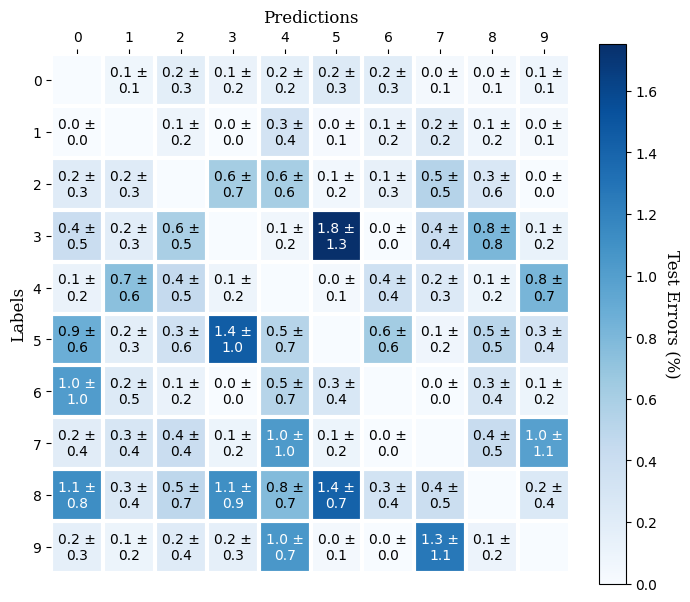

In [17]:
print(f"d* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=2, keepdims=True)
cm_mean = np.mean(confusion_matrix, axis=0); np.fill_diagonal(cm_mean, 0.)
cm_std = np.std(confusion_matrix, axis=0)
labels = np.array([f'{100*mean:.1f} ±\n{100*std:.1f}' for mean, std in zip(cm_mean.flatten(), cm_std.flatten())]).reshape(cm_mean.shape); np.fill_diagonal(labels, '')

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_ylabel('Labels', font='serif', size=12); axs.set_title('Predictions', font='serif', size=12)
im, cbar = heatmap(100*cm_mean, np.arange(10), np.arange(10), cmap='Blues', cbarlabel='Test Errors (%)', ax=axs)
texts = annotate_heatmap(im, labels=labels)
fig.tight_layout()
plt.show()

### Question 4

In [18]:
def hardest_samples(kernel, ys, coefs, n=5):

    '''
    Find the hardest samples to predict as the ones with the lowest pre-activation
    prediction given by the classifier corresponding to the class given by their label.
    
    Parameters
    ----------
    kernel: np.ndarray
        kernel matrix of the particular dataset we are finding the hardest samples from
    ys: np.ndarray
        labels for the dataset we are finding the hardest samples from
    coefs: np.ndarray
        k-class kernel perceptron coefficients
    n: int
        number of hardest samples to return

    Returs
    ------
    hardest_samples: np.ndarray
        indices of the {n} hardest samples from the given dataset
    '''

    predictions = predict(coefs, kernel)
    labels = np.full(predictions.shape, -1.); labels[ys.astype(int), np.arange(predictions.shape[1])] = 1.
    best_pred = np.max(labels*predictions, axis=0)
    hardest_samples = np.argpartition(best_pred, n)[:n]
    
    return hardest_samples

In [19]:
def plot(img, label, fn=None, show=False):
    
    fig, axs = plt.subplots(figsize=(4, 4))
    img = img.reshape(16, 16)
    axs.imshow(img, cmap='viridis', interpolation='none')
    axs.set_title(f'Label = {label}', fontdict={'font': 'serif', 'size': 16})
    axs.get_xaxis().set_visible(False); axs.get_yaxis().set_visible(False)
    fig.tight_layout()
    if fn is not None:
        fig.savefig(fn)
    if show:
        plt.show()
    else:
        plt.close(fig)

In [20]:
d = np.round(np.mean(results['hparam_star']))
full_kernel_d = full_kernel.kernel(d)

train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
train_kernel, test_kernel = full_kernel_d[np.ix_(train_indices, train_indices)], full_kernel_d[np.ix_(test_indices, train_indices)]
train_y, test_y = Y[train_indices], Y[test_indices]

coefs = init_coefs(n_classifiers, train_indices.size)
coefs, _ = train(train_kernel, train_y, coefs, n_epochs=N_EPOCHS)
indices = hardest_samples(test_kernel, test_y, coefs, n=5)
hardest_test_samples = test_indices[indices]

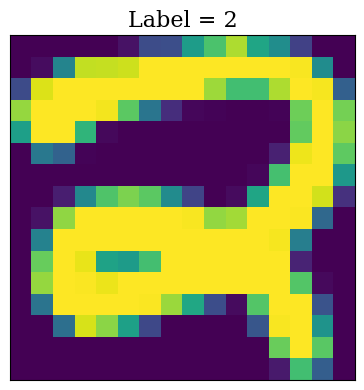

In [21]:
display = 1

dirpath = Path('assets')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
dirpath.mkdir(parents=True, exist_ok=True)

for index in hardest_test_samples:
    img, label = X[index], int(Y[index])
    plot(img, label, fn=f'{dirpath}/sample-{index}_label-{label}.png', show=False)

index = hardest_test_samples[display-1]
img, label = X[index], int(Y[index])
plot(img, label, fn=None, show=True)

### Question 5

In [22]:
class GaussianKernel(PolynomialKernel):

    '''
    Compute the Gaussian kernel with width c by first precomputing the 
    kernel matrix with c=1, and then raising it to the power c.

    Attributes
    ----------
    base_kernel_matrix: np.ndarray
        matrix containing pairwise Gaussian kernel evaluations for c=1
    
    Methods
    -------
    base_kernel(X1, X2):
        evaluate the kernel matrix between points in {X1} and {X2} with c=1
    '''

    def __init__(self, X1, X2=None):
        super().__init__(X1, X2)

    def base_kernel(self, X1, X2):

        '''
        Evaluate the width 1 Gaussian kernel matrix between {X1} and {X2}
        
        Parameters
        ----------
        X1: np.ndarray
            first data matrix of shape (N, D)
        X2: np.ndarray
            second data matrix of shape (M, D)
        
        Returns
        -------
        squared_exp_kernel: np.ndarray
            kernel matrix of shape (N, M) containing pairwise Gaussian kernel
            evaluations with c=1
        '''
        
        # evaluate the pairwise squared L2-distances
        squared_distances = np.sum(np.square(X1), axis=1, keepdims=True) + \
            np.sum(np.square(X2).T, axis=0, keepdims=True) - \
            2 * X1 @ X2.T
        # evaluate the {base_kernel_matrix} using Gaussian kernel of width 1 
        squared_exp_kernel = np.exp(-squared_distances)
        
        return squared_exp_kernel
    
full_kernel = GaussianKernel(X)

In [23]:
C = np.linspace(0.01, 0.04, num=7, endpoint=True)
error_rates = question_1(n_runs=N_RUNS, hparams=C, n_epochs=N_EPOCHS)

df = pd.DataFrame(data=zip(*error_rates.values()), index=np.round(C, 3), columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Width')
df

,Train error (%),Test error (%)
Width,,
0.010,0.163 ± 0.041,2.858 ± 0.372
0.015,0.081 ± 0.028,2.718 ± 0.343
0.020,0.066 ± 0.037,2.659 ± 0.248
0.025,0.063 ± 0.021,2.766 ± 0.470
0.030,0.055 ± 0.022,2.965 ± 0.332
0.035,0.052 ± 0.025,3.156 ± 0.351
0.040,0.054 ± 0.030,3.384 ± 0.415


In [24]:
results, = question_2(n_runs=N_RUNS, n_splits=N_SPLITS, hparams=C, n_epochs=N_EPOCHS, return_cm=False)

print(f"c* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

c* = 0.020 ± 0.004
Test error (%) = 2.605 ± 0.313


### Question 6

In [25]:
'''
class_combinations = [(0, 1), (0, 2), ..., (0, 9), (1, 2), ..., (1, 9), ..., (7, 8), (7, 9), (8, 9)]
    => if the prediction of classifier {k} is {y'} = 0/1, then the class voted for is class_combinations[k][y']

classifier_mapping = [[0, 1, ..., 8], [0, 9, 10, ..., 16], ..., [8, 16, 23, 29, 34, 38, 41, 43, 44]]
    => classifier_mapping[y] is a list of indices, [k], such that classifier {k} compares class {y} with another 
       class used for accessing the classifiers that need to be updated after seeing the training point (x, y)
'''

class_combinations, k = list(), -1
classifier_mapping = [[] for _ in range(N_CLASSES)]

for class_a in range(N_CLASSES):
    for k, class_b in enumerate(range(class_a+1, N_CLASSES), k+1):
        class_combinations.append((class_a, class_b))
        classifier_mapping[class_a].append(k); classifier_mapping[class_b].append(k)

class_combinations = np.array(class_combinations)
n_classifiers = k+1

In [26]:
def train(train_kernel, train_y, coefs, n_epochs=1):

    '''
    Train the k-class kernel perceptron using One-vs-One generalization.
    
    Parameters
    ----------
    train_kernel: np.ndarray
        pairwise kernel evaluations for the training points
    train_y: np.ndarray
        labels for the training set
    coefs: np.ndarray
        k-class kernel perceptron coefficients
    n_epochs: int
        number of epochs to train the classifier for

    Returns
    -------
    coefs: np.ndarray
        updated coefficients of the k-class kernel perceptron
    mistakes: List[int]
        mistakes made on the training set in each epoch
    '''

    # keep track of the mistakes made on the training set in each epoch
    mistakes = [0 for _ in range(n_epochs)]
    for epoch in range(n_epochs):
        for i in range(train_y.size):
            # retrieve the kernel evaluations between the new training point and the old ones
            features, y = train_kernel[i], train_y[i]
            # predict the pre-activation outputs and the class prediction
            predictions = predict(coefs, features)
            # aggregate the votes from each of the classifiers
            votes = class_combinations[np.arange(n_classifiers), (predictions>0.).astype(int)]
            # use hard voting to compute the majority vote
            vote_counts = np.bincount(votes); hard_mx = np.argmax(vote_counts)
            # if the prediction doesn't match the label, increment the number of mistakes
            if hard_mx != y:
                mistakes[epoch] += 1
            # extract the classifiers relevant to the data sample (ones that involve label {y})
            classifiers = classifier_mapping[int(y)]
            # extract the predictions from the relevant classifiers
            predictions = predictions[classifiers]
            # set the label for the classifiers comparing label {y} against another label y' 
            # as 1 and the labels for the rest of the classifiers as -1 
            labels = np.full(len(classifiers), -1.); labels[:int(y)] = 1.
            # update the coefficients for the classifiers which made a mistake
            updates = np.where(labels*predictions <= 0., sign(predictions), 0.)
            coefs[classifiers, i] -= updates

    return coefs, mistakes

def test(test_kernel, test_y, coefs, return_cm=False, return_confidence_scores=False):

    '''
    Test the k-class perceptron using One-vs-One generalization.
    
    Parameters
    ----------
    test_kernel: np.ndarray
        pairwise kernel evaluations for the test points with training points
    train_y: np.ndarray
        labels for the testing set
    coefs: np.ndarray
        k-class kernel perceptron coefficients
    return_cm: bool
        Boolean value indicating whether to return the confusion matrix
        (not used, only here for consistency)
    return_confidence_scores: bool
        Boolean value indicating whether to return the confidence scores
        for each of the 10 digit classes

    Returns
    -------
    mistakes: int
        mistakes made on the testing set
    confidence_scores: np.ndarray
        confidence of the classifier in assigning the input to each of the digit 
        classes, where confidence in a class <c> is defined as the ratio of the
        number of perceptrons voting for class <c>
    '''

    # make the pre-activation predictions on the test set
    predictions = predict(coefs, test_kernel)
    # extract the votes given by each classifier
    row_indices = np.tile(np.arange(predictions.shape[0]), (predictions.shape[1], 1)).T
    votes = class_combinations[row_indices, (predictions>0.).astype(int)]
    # make a counter for the votes given to each class
    vote_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=N_CLASSES), axis=0, arr=votes)
    # find the majority vote for each test point
    hard_mxs = np.argmax(vote_counts, axis=0)
    # compute mistakes as the number of incorrectly predicted labels
    mistakes = np.sum(hard_mxs != test_y)
    
    yield mistakes
    yield None

    if return_confidence_scores:
        # return the ratio of classifiers that voted in support of each of the classes
        yield vote_counts / coefs.shape[0]

In [27]:
full_kernel = PolynomialKernel(X)

In [28]:
error_rates = question_1(n_runs=N_RUNS, hparams=D, n_epochs=N_EPOCHS)

df = pd.DataFrame(data=zip(*error_rates.values()), index=D, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Degree')
df

,Train error (%),Test error (%)
Degree,,
1,5.401 ± 0.201,7.392 ± 0.754
2,1.538 ± 0.158,4.153 ± 0.431
3,0.795 ± 0.153,3.505 ± 0.700
4,0.542 ± 0.096,3.376 ± 0.555
5,0.362 ± 0.082,3.583 ± 0.815
6,0.303 ± 0.079,3.430 ± 0.378
7,0.218 ± 0.068,3.565 ± 0.474


In [29]:
results, = question_2(n_runs=N_RUNS, n_splits=N_SPLITS, hparams=D, n_epochs=N_EPOCHS, return_cm=False)

print(f"d* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

d* = 4.650 ± 0.910
Test error (%) = 3.304 ± 0.819


In [30]:
full_kernel = GaussianKernel(X)

In [31]:
error_rates = question_1(n_runs=N_RUNS, hparams=C, n_epochs=N_EPOCHS)

df = pd.DataFrame(data=zip(*error_rates.values()), index=C, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Width')
df

,Train error (%),Test error (%)
Width,,
0.010,0.573 ± 0.109,3.344 ± 0.365
0.015,0.349 ± 0.077,3.194 ± 0.386
0.020,0.255 ± 0.084,3.430 ± 0.494
0.025,0.195 ± 0.054,3.349 ± 0.390
0.030,0.142 ± 0.052,3.602 ± 0.373
0.035,0.146 ± 0.049,3.876 ± 0.432
0.040,0.130 ± 0.052,4.113 ± 1.104


In [32]:
results, = question_2(n_runs=N_RUNS, n_splits=N_SPLITS, hparams=C, n_epochs=N_EPOCHS, return_cm=False)

print(f"c* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

c* = 0.017 ± 0.003
Test error (%) = 3.199 ± 0.462
